In [1]:
import sys
sys.path.insert(0, '/Users/kedzie/Documents/Berkeley/notebooks/utilities')

import pdb
import pandas as pd
import numpy as np
import scipy
from matplotlib import rcParams as rc
rc['mathtext.default'] = 'regular'
import matplotlib.pyplot as plt
from collections.abc import Iterable
from utility_functions.utils import *
rc['font.size'] = 14

In [92]:
def baselinecorr(data, mz, end1, start2):
    #data is the DEMS mass spec dataframe, mz is the mass spec number you're interested in, ...
    # end1 is the end of initial ocv (in s), start2 is the start of baseline ocv after cycling (min)
    #find where the ocv ends by comparing eclab times with labview times

    
    index = getnearpos(data['time/min'], end1/60)-1
    index2 = getnearpos(data['time/min'], start2)
    endocvtime= getnearpos(data['time/min'], start2+50)
    plt.figure()
    plt.plot(data['time/min'], data[str(mz)], '--', label=str(mz))


    #convert mass data into dataframe variables
    d = {'time/min' : data['time/min'][3:index], str(mz) : data[str(mz)][3:index] }
    d2 =  {'time/min' : data['time/min'][index2:-30], str(mz): data[str(mz)][index2:-30] }

    df = pd.DataFrame(d); df2 = pd.DataFrame(d2)
    newdf = pd.DataFrame()
    newdf = pd.concat([df,df2])
    row,col= data.shape

    def slope(fullfile, mz, time1, time2):
        m=(fullfile[str(mz)].iloc[time2]-fullfile[str(mz)].iloc[time1])/(fullfile['time/min'].iloc[time2]-fullfile['time/min'].iloc[time1])
        return m
    
    def lin(fullfile,time,maz,cpstart,cpend):
        m= (maz.iloc[cpend]-maz.iloc[cpstart]) / (time.iloc[cpend]-time.iloc[cpstart])
        line=(m*(time-time.iloc[cpstart]) + maz.iloc[cpstart])
        return m 
    
    if mz == 2:
        m= slope( data, mz, index2-50, -10) # -300, -190)
        correct=(m)*(data['time/min']- data['time/min'].iloc[-10]) + data[str(mz)].iloc[-10] -0.001
        #correct = 4.667382*10**-9*data['time/min']- 0.2536795

        
    elif mz == 32:
        m= slope( data, mz, index2-50, -10 )
        correct = m * (data['time/min']- data['time/min'].iloc[index2-50]) + data[str(mz)].iloc[index2-50] -0.00
        
    elif mz == 44:
        m= slope( data, mz, index2+15, -5)
        #print('co2: ' + str(data['time/min'].iloc[index2+50]) + 'min')
        
        correct = m*(data['time/min']- data['time/min'].iloc[-15]) + data[str(mz)].iloc[-15]

    plt.plot(data['time/min'], correct, '.')
    
    data[str(mz)] = data[str(mz)]-correct
    
    plt.plot(data['time/min'], data[str(mz)], '-.', label='correction')
    plt.legend()                            
    
    return (data)
#---------------------- DEMS DATA ANALYSIS ---------------------
def read_dems(file):
    df = pd.read_csv(file, sep ='\t')
    df = df.rename(columns=lambda x: x.replace('.00000', ''))
    df.rename(columns={'0':'time/min', '0.1':'temperature/C', '0.2': 'pressure/torr', '0.3':'current/mA', '0.4':'voltage/V'}, inplace= True)
    #normalize time function
    df['time/min'] = df['time/min']-df['time/min'].iloc[0]
    
    return df

def find_charge(fold):
    import os
    files = os.listdir(fold)
    import re 
    regex = 'chrg'
    look='mpt'
    #find the file names that have 'chrg' in the name and then find only the ones of those that are .mpt files
    all_chrg= [fold + f for f in files if re.search(regex, f)]
    chrg_ec = [ i for i in all_chrg if re.search(look, i)]
    chrg_ec.sort()

    #read in the mpts as dataframes and put in list ls
    ls=[]
    for i in range(len(chrg_ec)):
        ls.append(read_data(chrg_ec[i]))
        
    #normalize all the dataframes by time zero in first dataframe
    for i in range(len(ls)):
        ls[i]['time/s']= ls[i]['time/s']-ls[0]['time/s'].iloc[0]
    
    return(ls)

def convert_ion_current(demsdata):
    #slopes and intercepts in an array [oxygen, co2, hydrogen, ethylene, carbon monoxide]
    #m = [1.144462577, 1.041140556, 0.06148247455, 1.690955209, 0.7959230955]
    #m = [1.463047028, 1.255655142, 0.06148247455*1.2, 1.690955209, 0.7959230955] #9/2018
    #m = [1.1513186, 1.01161546, 0.06148247455, 1.690955209, 0.7959230955] #2/2019
    m = [1.463047028, 1.4379, 0.052035, 1.690955209, 0.7959230955] #6/29/20  1.646
    #inf_ar = 278.6590323 * demsdata['36']
    inf_ar = 286.5408 * demsdata['36']   #as of 6/2020

    vol = 499 #uL *10^-6 
    R = 62.363577 #  L*torr / (K*mol)
    temp = demsdata['temperature/C']+273
    #covert all pressures into umoles
    demsdata['2'] = (m[2] * demsdata['2']/inf_ar ) * demsdata['pressure/torr']*vol/R/ (temp)    
    demsdata['26'] = (m[3] * demsdata['26'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (temp)
    demsdata['28'] = (m[4] * demsdata['28'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (temp)    
    demsdata['32'] = (m[0] * demsdata['32'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (temp)
    demsdata['34'] = (m[0] * demsdata['34'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (temp)
    #demsdata['36'] = (m[0] * demsdata['36'] *10**-9/inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['44'] = (m[1] * demsdata['44'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (temp)
    demsdata['45'] = (m[1] * demsdata['45'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (temp)
       
    return (demsdata) 

def integrate_peaks(time_h_start, time_h_end, demsdata, mz):
    time_min_start = time_h_start * 60
    time_min_end = time_h_end * 60
    
    start_int = getnearpos(demsdata['time/min'], time_min_start)
    end_int = getnearpos(demsdata['time/min'], time_min_end)
    print(start_int, end_int)
    
    peak_value = np.cumsum(demsdata[str(mz)]).iloc[end_int] - np.cumsum(demsdata[str(mz)]).iloc[start_int]
    return (peak_value)

In [93]:
def plot_naion_dems(chrg_ec, demi, r, ethylene='None', n=1 , percent='off', weight=1):
    num = len(chrg_ec)
    
    end_ocv= chrg_ec[num-1]['time/s'].iloc[0]/60
    
    umolesdf = convert_ion_current(demi) 
    oxy = baselinecorr( demi, 32, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    hydro = baselinecorr( oxy, 2, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    co2 = baselinecorr( hydro, 44, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    
    umolesdf=co2
    
    #convert ion current to moles of gas for baseline corrected data
    timediff= np.mean(np.gradient(umolesdf['time/min']))
    charge_i= np.mean(chrg_ec[1]['I/mA'])
    
    #charge_start= chrg_ec[1]['time/s'].iloc[0]/60 #find the start time for charge in eclab
    
    cap=[]
    curr=[]
    
    new= chrg_ec[1]
        
    for j in range(len(umolesdf)):  
        index=getnearpos( chrg_ec[1]['time/s'], (umolesdf['time/min'].iloc[j]*60))
        #index=np.argmin(np.abs(new['time/s']-umolesdf['time/min'].iloc[j]*60).values)
        if umolesdf['time/min'].iloc[j] * 60 <= chrg_ec[1]['time/s'].iloc[-1]:
            cap.append( new['Capacity/mA.h'].iloc[index])
            curr.append( new['I/mA'].iloc[index])
        else:
            cap.append((umolesdf['time/min'].iloc[j]-chrg_ec[0]['time/s'].iloc[-1]/60)/60*charge_i)
            curr.append(0)
            

    umolesdf['Capacity/mAh'] = cap
    umolesdf['I/mA'] = curr
    
    
    x = [0.0, 16]
    y = [3.6*charge_i/60/(n*96485)*10**6, 3.6 * charge_i/(n*96485*60)*10**6]
    
    fig,ax = plt.subplots(figsize= (7,5), facecolor='None')
    
    ax2=ax.twinx()
    start_charge= getnearpos(umolesdf['time/min'], 12.55*60) #chrg_ec[0]['time/s'].iloc[-1]/60)
    end_charge=getnearpos(umolesdf['time/min'], 22*60) #chrg_ec[num-1]['time/s'].iloc[-1]/60)  
    umoles_32 = np.cumsum(umolesdf['32']).iloc[end_charge] - np.cumsum(umolesdf['32']).iloc[start_charge]
    umoles_2 = np.cumsum(umolesdf['2']).iloc[end_charge] - np.cumsum(umolesdf['2']).iloc[start_charge]
    umoles_44 = np.cumsum(umolesdf['44']).iloc[end_charge] - np.cumsum(umolesdf['44']).iloc[start_charge]
    
    total_moles = umoles_32 + umoles_2 + umoles_44
    total_umoles= umolesdf['2']+umolesdf['32']+umolesdf['44']
    print ('o2: '+ str(umoles_32) + " " + str(umoles_32/total_moles*100) + '% ', 'h2: ' + str(umoles_2) +  " " + str(umoles_2/total_moles*100) + '% ', str(umoles_44) +  " " + str(umoles_44/total_moles*100) + '%')
    
    factor = 1
    col=1
    if percent=='on':
        col = 3
        ax2.plot(umolesdf['Capacity/mAh'][4:49] , (umolesdf['32']/total_umoles*100/weight)[6:51] , 's:', markersize=4, label='O$_2$', color='xkcd:pinkish')
        ax2.plot(umolesdf['Capacity/mAh'][7:50], (umolesdf['2']/total_umoles*100/weight)[7:50] , 'o:', markersize=4, label= 'H$_2$', color='xkcd:tangerine')
        ax2.plot(umolesdf['Capacity/mAh'][7:50], (umolesdf['44']/total_umoles*100/weight)[7:50] , 'o:', markersize=4, label= 'CO$_2$', color='xkcd:maroon', alpha=0.9)
    else:
        col = 4
        
        ax2.plot(umolesdf['time/min'][3:]/60, (umolesdf['32']/timediff)[3:] , 's:', markersize=6, label='O$_2$', color='xkcd:pinkish')
        ax2.plot(umolesdf['time/min'][2:]/60, (umolesdf['44']/timediff/weight)[2:] , 'v:', markersize=6, label = 'CO$_2$', color='xkcd:maroon')
        ax2.plot(umolesdf['time/min'][1:]/60, (umolesdf['2']/timediff/weight)[1:] , 'o:', markersize=6, label= 'H$_2$', color='xkcd:tangerine')
        ax2.plot(umolesdf['time/min'][start_charge:end_charge]/60, (umolesdf['2']/timediff/weight)[start_charge:end_charge] , 'o:', markersize=6, label= 'H$_2$ lag', color='k')

    #print('lag time = ', (umolesdf['time/min'].iloc[235] - umolesdf['time/min'].iloc[195]))
    #ax.plot(x,y, 'k--', label= str(n)+ 'e$^-$ / O$_2$')
    ax2.legend( loc = 'upper right', prop={"size":12}, ncol=3) #title= 'm/z value')
    #ax2.legend(loc='upper center', prop={"size":14}) #, bbox_to_anchor=(0.5, 1.15), ncol=col, fancybox=True, shadow=True, prop={"size":14})
    for i in range(0,num):
        #if i <5:
        ax.plot(chrg_ec[i]['time/s']/60/60, chrg_ec[i]['Ewe/V'],'xkcd:ocean blue', markevery = 0.01, linewidth = 2.5) 
        #else:
            #ax.plot((chrg_ec[i]['time/s']+ 8.3654*10**4)/60/60, chrg_ec[i]['Ewe/V'],'xkcd:ocean blue', markevery = 0.01, linewidth = 2.5) 

    ax.set_xlabel('Time (h)', fontsize=20)
    ax.set_ylabel('Potential (V vs. Na/Na$^+$)', color='xkcd:ocean blue', fontsize=20)
    ax2.set_ylabel('Gas Evolution ($\mu$mol / (min * mg))', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='y', which='major', labelsize=18, length = 6)
    
    #plt.xticks(np.arange(0, 1.05, step=0.1))
    epermol= chrg_ec[1]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)   
    print('umoles O2: '+ str(umoles_32))   
    print('e per mol: ' + str(epermol))
    #ax2.set_ylim(-0.0005, .004)
    #ax.set_ylim(-1,2.8)
    
    
    #h2cycle1 = integrate_peaks(1,25, umolesdf, '2')
   # h2cycle2 = integrate_peaks(25,45, umolesdf, '2')
    #print(h2cycle1, 'h2')
    
    return



o2: -0.05132080715077788 -266.3197146803225%  h2: 0.06548323113514443 339.81296087220517%  0.005107950802712563 26.506753808117274%
umoles O2: -0.05132080715077788
e per mol: -121.57423166315581


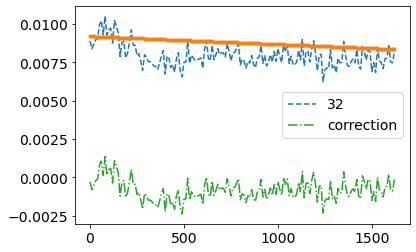

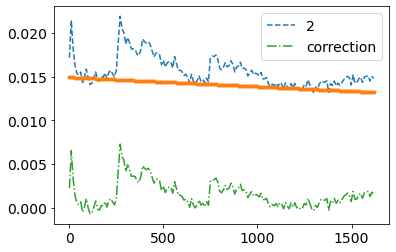

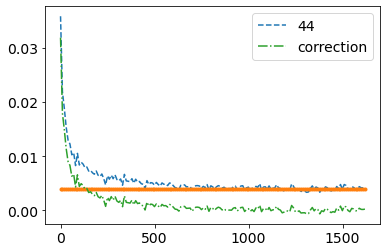

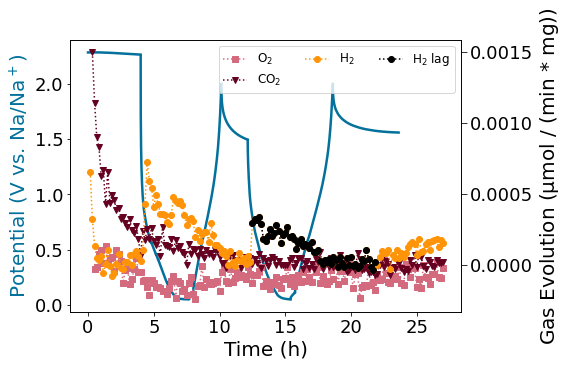

In [94]:
hydratedtrode = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200902_EAK-WY-NaTiO4_hydratedelectrode_dems/200902_EAK-WY-NaTiO4_hydratedelectrode_dems_2020-09-02_17.27_23-2.txt')
wei_ec = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200902_EAK-WY-NaTiO4_hydratedelectrode_dems/')


#plot_naion_dems(wei_ec, hydratedtrode, 1, 1.288)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200902_EAK-WY-NaTiO4_hydratedelectrode_dems/200902_EAK-WY-NaTiO4_hydratedelectrode_dems_h2.png', transparent= True, dpi=800, bbox_inches='tight')



overnighthydrated = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201023_EAK-WY-NaTiO4_hydratedelectrode_overnightrest_c5_cycling/201023_EAK-WY-NaTiO4_hydratedelectrode_c5_overnightrest_dems_2020-10-23_11.55_19-2.txt')
ecfolder= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201023_EAK-WY-NaTiO4_hydratedelectrode_overnightrest_c5_cycling/')
#plot_naion_dems(ecfolder, overnighthydrated, 1, 0.938)
#plt.xlim(-2, 45)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201023_EAK-WY-NaTiO4_hydratedelectrode_overnightrest_c5_cycling/201023_EAK-WY-NaTiO4_hydratedelectrode_c5_dems.png', transparent= True, dpi=800, bbox_inches='tight')



# plt.figure()
# i=32
# plt.plot(overnighthydrated['time/min']/60, overnighthydrated[str(i)], label = 'm/z= ' +str(i))
# plt.legend()



overnightdehydrated = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201108_WeiYin_NaTiO_dehydratedelectrode_overnightrest/201109_EAK_WY_NaTiO_dehydratedelectrode_c5_overnightrest_dems_2020-11-09_10.17_29.txt')
ovde_ec= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201108_WeiYin_NaTiO_dehydratedelectrode_overnightrest/')
#plot_naion_dems(ovde_ec, overnightdehydrated, 1, 1.57)
#plt.xlim(-2, 45)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201108_WeiYin_NaTiO_dehydratedelectrode_overnightrest/201108_WeiYin_NaTiO_dehydratedelectrode_overnightrest_dems.png', transparent= True, dpi=800, bbox_inches='tight')


overnight500NTO = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201229_EAK_WY_NTO500_overnightrest_dems/201229_EAK_WY_NTO500_overnightrest_dems_2020-12-29_10.47_08.txt')
NTOec = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201229_EAK_WY_NTO500_overnightrest_dems/')
plot_naion_dems(NTOec, overnight500NTO, 1, 1.428)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201229_EAK_WY_NTO500_overnightrest_dems/201229_EAK_WY_NTO500_overnightrest_dems.png', transparent= True, dpi=800, bbox_inches='tight')



In [111]:
ion signals: 2, 19, 39

SyntaxError: invalid syntax (<ipython-input-111-bdef2e642f06>, line 1)

o2: -0.11229598496297014 -6.214128696937144%  h2: 0.6236080885492661 34.50863287742624%  1.2957953838772198 71.7054958195109%
umoles O2: -0.11229598496297014
e per mol: -140.5602588717092
12 300
[9.63502621e-05]
[0.01081489]
300 541
[0.00172551]
[9.63502621e-05]
[-0.01071854]
[0.00162916]


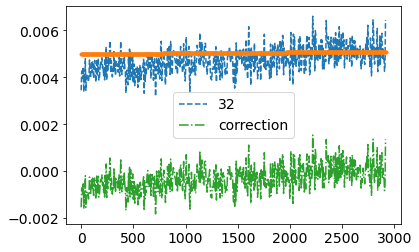

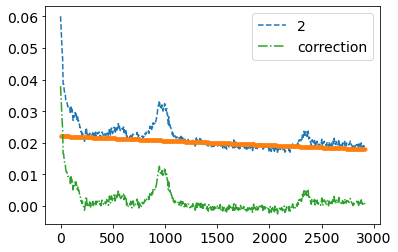

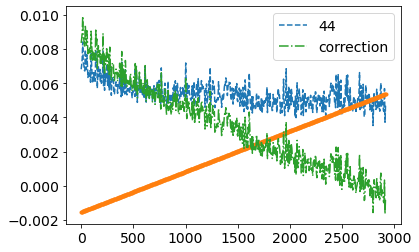

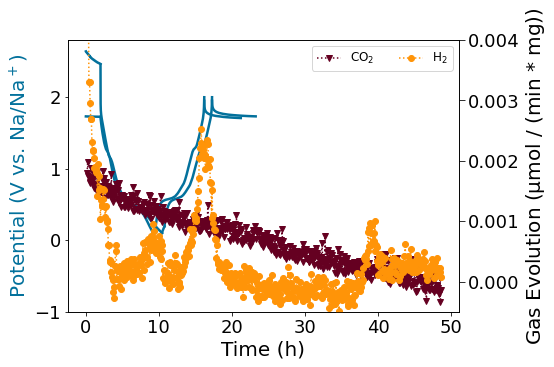

In [20]:
dehydratedelectrode = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201001_EAK-WY-NaTiO4_dehydratedelectrode_c5_dems/201001_dehydratedelectrode_c5_dems_bothcycles.txt')
elec_folder = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201001_EAK-WY-NaTiO4_dehydratedelectrode_c5_dems/')
endtime = elec_folder[4]['time/s'].iloc[-1]
# for j in range (5,9):
#     for i in range (0, len(elec_folder[j]['time/s'])):
#         elec_folder[j]['time/s'].iloc[i] + endtime
        
# elec_folder[5]['time/s'] + elec_folder[4]['time/s'].iloc[-1]
# elec_folder[6]['time/s'] + elec_folder[4]['time/s'].iloc[-1]
# elec_folder[7]['time/s'] + elec_folder[4]['time/s'].iloc[-1]
# elec_folder[8]['time/s'] + elec_folder[4]['time/s'].iloc[-1]

plot_naion_dems(elec_folder, dehydratedelectrode, 1, 1.57)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201001_EAK-WY-NaTiO4_dehydratedelectrode_c5_dems/201001_EAK-WY-NaTiO4_dehydratedelectrode_c5_dems_cycling.png', transparent= True, dpi=800, bbox_inches='tight')





o2: 8.044350769656223e-05 -0.06947984104846683%  h2: -0.48874834512189325 422.1367056725394%  0.3728882646969972 -322.067225831491%
umoles O2: 8.044350769656223e-05
e per mol: 13142.490111821275
6 133
[0.00211143]
[-0.01197457]
133 133
[0.00211143]
[0.00211143]
[0.014086]
[0.]


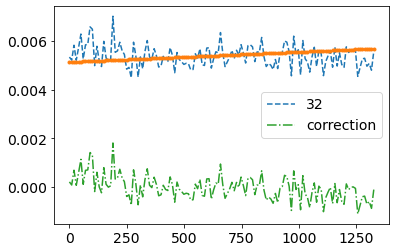

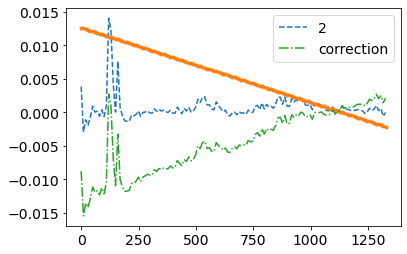

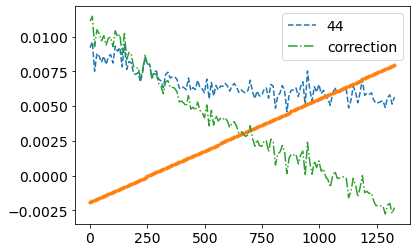

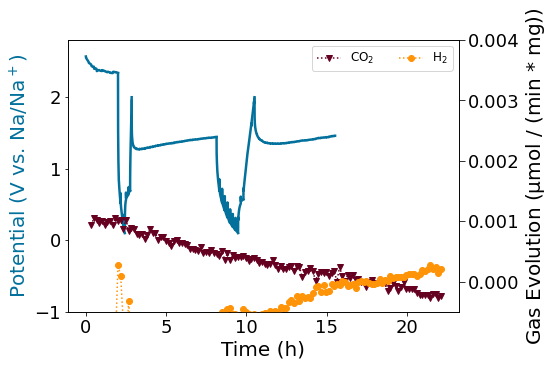

In [8]:
dehydratedpowder = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200916_EAK_WY_CTO_O6_dehydratedpowder_cycle/200916_EAK_WY_CTO_O6_dehydratedpowder_dems_cycles_baseline_fixed.txt')
pow_folder = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200916_EAK_WY_CTO_O6_dehydratedpowder_cycle/')

plot_naion_dems(pow_folder, dehydratedpowder, 1, 2.1)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200916_EAK_WY_CTO_O6_dehydratedpowder_cycle/200916_EAK_WY_CTO_O6_dehydratedpowder_cycling.png', transparent= True, dpi=800, bbox_inches='tight')



o2: 0.1572745614947411 5.309455781754733%  h2: 0.07630766232947395 2.576081949279259%  2.728577514565453 92.11446226896601%
umoles O2: 0.1572745614947411
e per mol: 33.273850726750695
12 235
[0.00190867]
[-0.00849838]
235 235
[0.00190867]
[0.00190867]
[0.01040705]
[0.]
o2: 0.017906703175696814 -10.045272265444071%  h2: 0.010366886209125736 -5.815598409922992%  -0.20653359770033847 115.86087067536705%
umoles O2: 0.017906703175696814
e per mol: 114.05594521117492
30 179
[0.00080063]
[-0.00915027]
179 179
[0.00080063]
[0.00080063]
[0.00995091]
[0.]


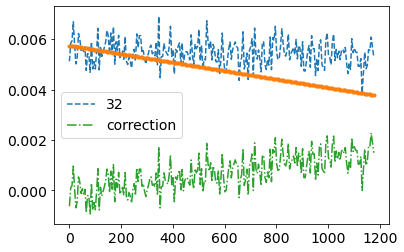

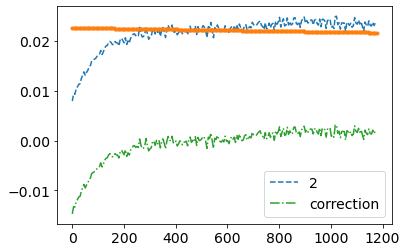

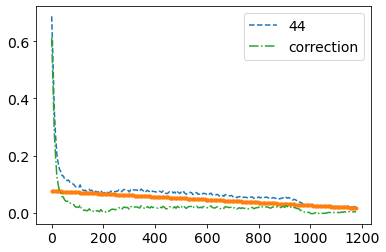

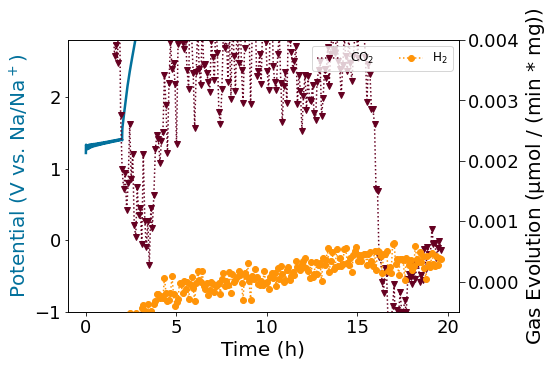

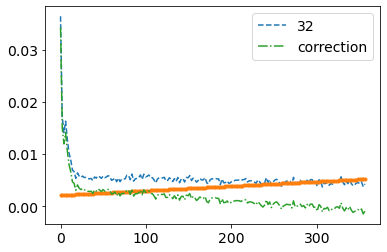

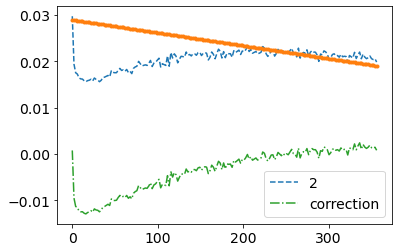

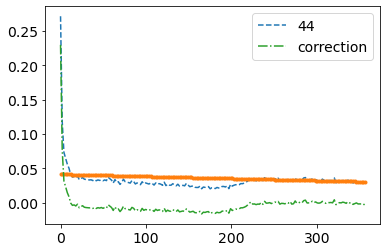

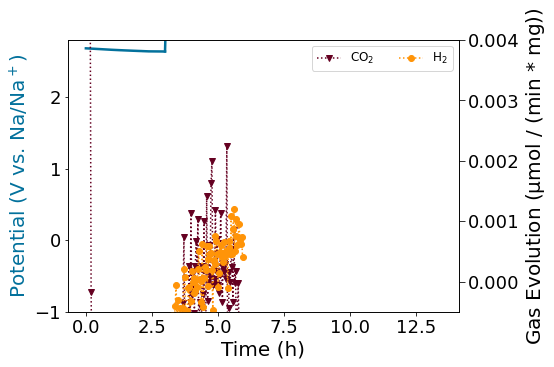

In [6]:
nopretreatmentcharge = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200924_Li-CO2cell_nopretreatment_discharge/200924_Li-CO2cell_nopretreatment_discharge_chrg_dems_2020-09-25_12.26_45.txt')
co2fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200924_Li-CO2cell_nopretreatment_discharge/')
chrg = co2fold[0:3]
plot_naion_dems(chrg, nopretreatmentcharge, 1)

O2prechrg = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200924_Li-CO2cell_O2pretreatment_discharge/200924_Li-CO2cell_O2pretreatment_chrg_v2_2020-09-27_16.05_42.txt')
O2fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200924_Li-CO2cell_O2pretreatment_discharge/')
O2chrg = O2fold[0:3]
plot_naion_dems(O2chrg, O2prechrg, 1)



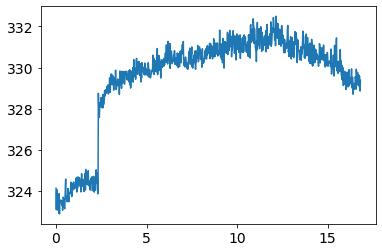

In [152]:
o2rest = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200924_Li-CO2cell_O2pretreatment_discharge/200924_Li-CO2cell_O2pretreatment_discharge_Ch1__2020-09-24_18.56_47.txt')

plt.figure()
plt.plot(o2rest['time/s'][:-20]/3600, o2rest['pressure/torr'][:-20]/o2rest['temperature/C'][:-20]+273)


o2: 45.25461485979191 99.18029938300278%  h2: 0.21040058112901935 0.46111524076353305%  0.16361760547972037 0.3585853762336786%
umoles O2: 45.25461485979191
e per mol: 0.8246260750496737
20 54
[-0.00495586]
[-0.00384378]
54 54
[-0.00495586]
[-0.00495586]
[-0.00111208]
[0.]


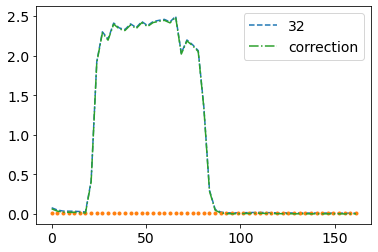

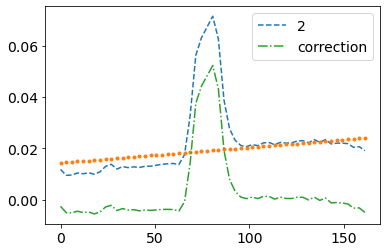

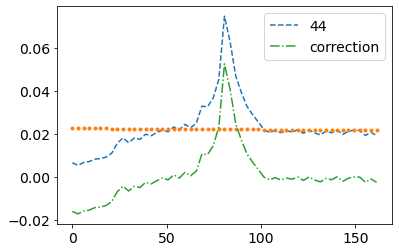

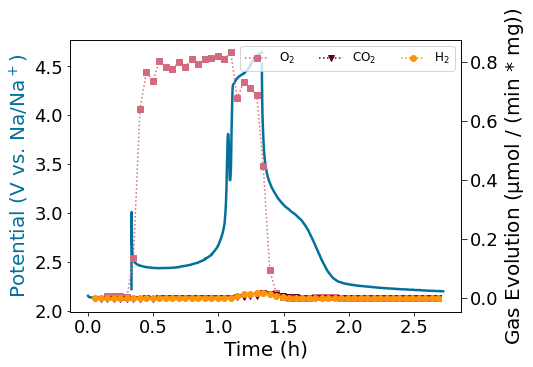

In [123]:
my_data= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180928_Na_chronopotent_cycling_2cycles_dems/180928_Na_chronopotent_cycling_2cycles_dems_chrg_cycle1_2018-09-28_16.40_19.txt')
my_data_folder = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180928_Na_chronopotent_cycling_2cycles_dems/')
plot_naion_dems(my_data_folder[0:3],my_data, 1,1 )